<a href="https://colab.research.google.com/github/rohanBrid18/ML-Workshop/blob/master/Keras_Fashion_MNIST_TPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%%capture
!pip install watermark

In [2]:
%load_ext watermark
%watermark -p tensorflow,numpy -m

tensorflow 1.14.0-rc1
numpy 1.16.4

compiler   : GCC 8.0.1 20180414 (experimental) [trunk revision 259383
system     : Linux
release    : 4.14.79+
machine    : x86_64
processor  : x86_64
CPU cores  : 2
interpreter: 64bit


(Adapted from https://github.com/tensorflow/tpu/blob/master/tools/colab/fashion_mnist.ipynb)

In [0]:
import os
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit

In [0]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

# add empty color dimension
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

In [5]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.Series(x_train.reshape(-1)).describe()

count   47040000.000
mean          72.940
std           90.021
min            0.000
25%            0.000
50%            0.000
75%          163.000
max          255.000
dtype: float64

In [6]:
pd.Series(y_train.reshape(-1)).describe()

count   60000.000
mean        4.500
std         2.872
min         0.000
25%         2.000
50%         4.500
75%         7.000
max         9.000
dtype: float64

In [7]:
sss = StratifiedShuffleSplit(n_splits=5, random_state=0, test_size=1/6)
train_index, valid_index = next(sss.split(x_train, y_train))
x_valid, y_valid = x_train[valid_index], y_train[valid_index]
x_train, y_train = x_train[train_index], y_train[train_index]
print(x_train.shape, x_valid.shape, x_test.shape)

(50000, 28, 28, 1) (10000, 28, 28, 1) (10000, 28, 28, 1)


In [0]:
def create_model():
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.BatchNormalization(input_shape=x_train.shape[1:]))
  model.add(tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='elu'))
  model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
  model.add(tf.keras.layers.Dropout(0.25))

  model.add(tf.keras.layers.BatchNormalization(input_shape=x_train.shape[1:]))
  model.add(tf.keras.layers.Conv2D(128, (5, 5), padding='same', activation='elu'))
  model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
  model.add(tf.keras.layers.Dropout(0.25))

  model.add(tf.keras.layers.BatchNormalization(input_shape=x_train.shape[1:]))
  model.add(tf.keras.layers.Conv2D(256, (5, 5), padding='same', activation='elu'))
  model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
  model.add(tf.keras.layers.Dropout(0.25))

  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(256))
  model.add(tf.keras.layers.Activation('elu'))
  model.add(tf.keras.layers.Dropout(0.5))
  model.add(tf.keras.layers.Dense(10))
  model.add(tf.keras.layers.Activation('softmax'))
  model.summary()
  return model

In [9]:
resolver = tf.contrib.cluster_resolver.TPUClusterResolver('grpc://' + os.environ['COLAB_TPU_ADDR'])
tf.contrib.distribute.initialize_tpu_system(resolver)
strategy = tf.contrib.distribute.TPUStrategy(resolver)

with strategy.scope():
  model = create_model()
  model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3, ),
      loss='sparse_categorical_crossentropy',
      metrics=['sparse_categorical_accuracy']
  )

W0626 14:37:42.239089 139705469757312 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W0626 14:37:51.151309 139705469757312 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 28, 28, 1)         4         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 64)        1664      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 128)       204928    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 128)         0

In [10]:
model.fit(
    x_train.astype(np.float32), y_train.astype(np.float32),
    epochs=15,
    steps_per_epoch=50,
    validation_data=(x_test.astype(np.float32), y_test.astype(np.float32)),
    validation_freq=15
)

model.save_weights('./fashion_mnist.h5', overwrite=True)

W0626 14:38:33.135234 139705469757312 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training_distributed.py:411: Variable.load (from tensorflow.python.ops.variables) is deprecated and will be removed in a future version.
Instructions for updating:
Prefer Variable.assign which has equivalent behavior in 2.X.


Epoch 1/15
50/50 [==============================] - 4s 83ms/step - loss: 1.3285 - sparse_categorical_accuracy: 0.6443
Epoch 2/15
50/50 [==============================] - 1s 23ms/step - loss: 0.5880 - sparse_categorical_accuracy: 0.7977
Epoch 3/15
50/50 [==============================] - 1s 23ms/step - loss: 0.4828 - sparse_categorical_accuracy: 0.8342
Epoch 4/15
50/50 [==============================] - 1s 23ms/step - loss: 0.4177 - sparse_categorical_accuracy: 0.8572
Epoch 5/15
50/50 [==============================] - 1s 23ms/step - loss: 0.3798 - sparse_categorical_accuracy: 0.8672
Epoch 6/15
50/50 [==============================] - 1s 23ms/step - loss: 0.3427 - sparse_categorical_accuracy: 0.8793
Epoch 7/15
50/50 [==============================] - 1s 23ms/step - loss: 0.3211 - sparse_categorical_accuracy: 0.8862
Epoch 8/15
50/50 [==============================] - 1s 24ms/step - loss: 0.3036 - sparse_categorical_accuracy: 0.8915
Epoch 9/15
50/50 [==============================] - 1s 2

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_3 (Batch (None, 28, 28, 1)         4         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 64)        1664      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 128)       204928    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 7, 128)        

<Figure size 288x216 with 0 Axes>

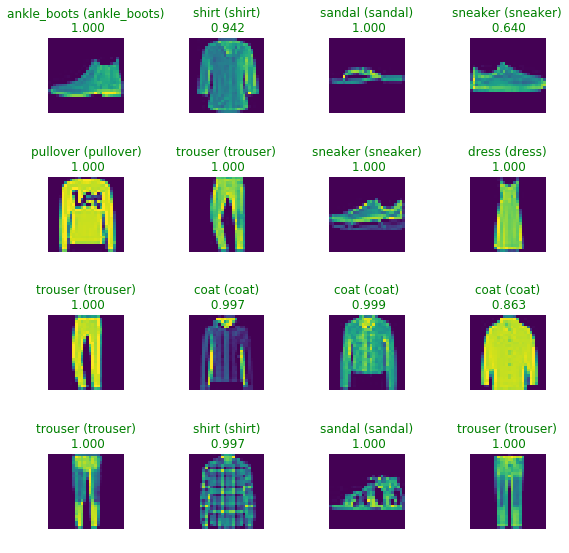

In [11]:
LABEL_NAMES = ['t_shirt', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle_boots']

cpu_model = create_model()
cpu_model.load_weights('./fashion_mnist.h5')

cpu_model.compile(
    optimizer=tf.train.AdamOptimizer(learning_rate=1e-3, ),
    loss=tf.keras.losses.sparse_categorical_crossentropy,
    metrics=['sparse_categorical_accuracy']
)

from matplotlib import pyplot
%matplotlib inline

def plot_predictions(images, predictions, true_labels):
  n = images.shape[0]
  nc = int(np.ceil(n / 4))
  fig = pyplot.figure(figsize=(4,3))
  # axes = fig.add_subplot(nc, 4)
  f, axes = pyplot.subplots(nc, 4)
  f.tight_layout()
  for i in range(nc * 4):
    y = i // 4
    x = i % 4
    axes[x, y].axis('off')
    
    label = LABEL_NAMES[np.argmax(predictions[i])]
    confidence = np.max(predictions[i])
    if i > n:
      continue
    axes[x, y].imshow(images[i])
    pred_label = np.argmax(predictions[i])
    axes[x, y].set_title("{} ({})\n {:.3f}".format(
      LABEL_NAMES[pred_label], 
      LABEL_NAMES[true_labels[i]],
      confidence
    ), color=("green" if true_labels[i] == pred_label else "red"))
  pyplot.gcf().set_size_inches(8, 8)  

plot_predictions(
    np.squeeze(x_test[:16]), 
    cpu_model.predict(x_test[:16]),
    y_test[:16]
)

In [12]:
%%time
# Evaluate the model on valid set
score = cpu_model.evaluate(x_valid, y_valid, verbose=0)

# Print test accuracy
print('\n', 'Valid accuracy:', score[1])


 Valid accuracy: 0.926
CPU times: user 471 ms, sys: 49.1 ms, total: 520 ms
Wall time: 4.27 s


In [13]:
%%time
# Evaluate the model on test set
score = cpu_model.evaluate(x_test, y_test, verbose=0)

# Print test accuracy
print('\n', 'Test accuracy:', score[1])


 Test accuracy: 0.9147
CPU times: user 480 ms, sys: 61.1 ms, total: 542 ms
Wall time: 3.58 s
